# Explore Data

The simulator generates JPG images with dimensions 320x160x3, for 3 different camera positions labeled center, left and right, also time-stamped. The time stamp show that the average sample is around 10Hz. Below are a sample for this images.

### Define project specific python constants

In [1]:
SIMULATOR_DIR = "/home/porko/Descargas/simulator-linux/"
#SIMULATOR_DIR = "../simulator-linux/"
IMG_DIR       = SIMULATOR_DIR + "IMG/"
LABEL_CSV     = SIMULATOR_DIR + "driving_log.csv"
%pwd
%cd /home/porko/workspace/nd_selfDrive/CarND-Behavioral-Cloning-P3

/home/porko/workspace/nd_selfDrive/CarND-Behavioral-Cloning-P3



11372


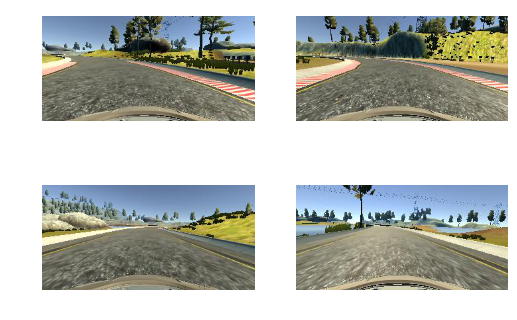

Done


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob

center_imgs = glob(IMG_DIR+"center*")
print()
print(len(center_imgs))
center_arr = []
# Read only a sample of 10 images
for img in center_imgs[:4]:
    center_arr.append(mpimg.imread(img))

def plot_imgArr(img_arr, label=None, predict=None, gray=False):
    f, arr = plt.subplots(2,2)
    for n, subplt in enumerate(arr.reshape(-1)):
        if gray:
            subplt.imshow(img_arr[n],  cmap='gray')
        else:
            subplt.imshow(img_arr[n])
        subplt.axis('off')
        if label is not None and predict is None:
            subplt.set_title("steer: "+str(label[n]))
        elif label is not None and predict is not None:
            subplt.set_title("st:"+str(label[n]) + "p:"+str(predict[n]))
    plt.show()

plot_imgArr(center_arr)
print("Done")

In the images above we can se that some parts of it may not be of use for the network and may cause waste of time and memory resources. 
Then we can crop the upper part, and also part of the bottom where a part of the car is visible.

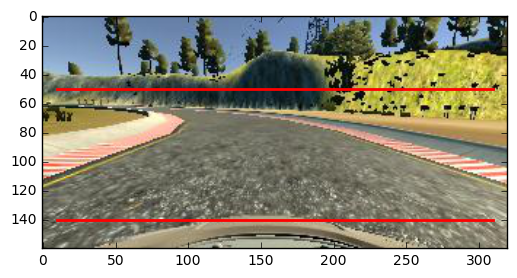

In [3]:
# select an image to visualize the region to crop
crop_img = plt.imread(center_imgs[1])
# Define the area of interest
BOTTOM_MARGIN = 50
TOP_MARGIN = 140
# Lines are defines as [x0, x1,...,xn], [y0, y1,...,yn]
plt.plot([10, 310], [BOTTOM_MARGIN, BOTTOM_MARGIN], 'r-', lw=2)
plt.plot([10, 310], [TOP_MARGIN, TOP_MARGIN], 'r-', lw=2)
plt.imshow(crop_img);
# Draw the crop lines

In the image the red lines indicate the new limit of the image, then we will apply this reduction to all the center images.

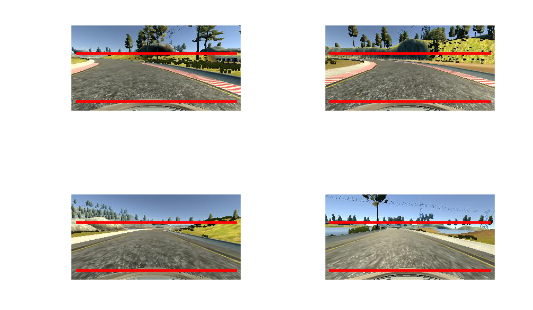

In [4]:
f, arr = plt.subplots(2,2)
for n, subplt in enumerate(arr.reshape(-1)):
    subplt.imshow(center_arr[n])
    subplt.axis('off')
    subplt.plot([10, 310], [BOTTOM_MARGIN, BOTTOM_MARGIN], 'r-', lw=2)
    subplt.plot([10, 310], [TOP_MARGIN, TOP_MARGIN], 'r-', lw=2)
plt.show()

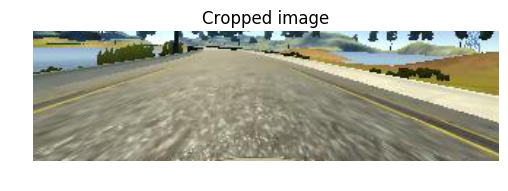

In [5]:
# apply the crop in all the images
import cv2
img = plt.imread(center_imgs[3])
crop_img = img[50:140]
plt.axis('off')
plt.title("Cropped image")
plt.imshow(crop_img);

#### Learning Note:
OpenCV reads the RGB colors in inverse order as maplotlib, this makes the image to look weird and possibly affects the recognition in the CNNs.
To solve this we need to, either use only OpenCV library or only Matplotlibs or reverse the color order in the array spending instructions.

http://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/

# Analyze the generated CSV:

This is the content of the csv:
`center_img` | `left_img` | `rigth_img` | `steering_angle` | `throttle` | `Break` | `Speed`

In [6]:
import csv

labels_csv = csv.reader(open(LABEL_CSV, "r"))

steering_angles = []
center_imgs_path = []
left_imgs_path = []
rigth_imgs_path = []
data = {"center_path": center_imgs_path, "left_path":left_imgs_path, "rigth_path": rigth_imgs_path, "label":steering_angles}
for line in labels_csv:
    # if using udacity data add SIMULATOR_DIR to image path
    center_imgs_path.append(SIMULATOR_DIR + line[0])
    left_imgs_path.append(line[1])
    rigth_imgs_path.append(line[2])
    steering_angles.append(float(line[3]))

In the current project, our output is the steering angle. As we did in previous projects, we need to check if our data is well distributed, this way the model will be capable of better generalization in the future in comparison to skewed data.

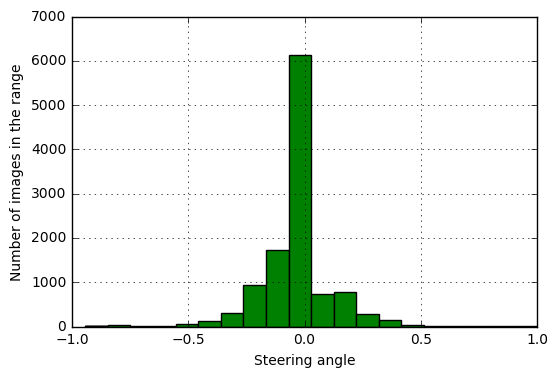

|n|:    4   n: -0.94 
|n|:   29   n: -0.85 
|n|:    4   n: -0.75 
|n|:    7   n: -0.65 
|n|:   52   n: -0.55 
|n|:  135   n: -0.46 
|n|:  302   n: -0.36 
|n|:  947   n: -0.26 
|n|: 1731   n: -0.17 
|n|: 6131   n: -0.07 
|n|:  738   n: 0.03 
|n|:  774   n: 0.13 
|n|:  290   n: 0.22 
|n|:  155   n: 0.32 
|n|:   41   n: 0.42 
|n|:    7   n: 0.51 
|n|:    6   n: 0.61 
|n|:    2   n: 0.71 
|n|:    1   n: 0.81 
|n|:   16   n: 0.90 


In [7]:
n, bins, _ = plt.hist(steering_angles, facecolor='green',  bins=20)
plt.xlabel('Steering angle')
plt.ylabel('Number of images in the range')
plt.grid(True)
plt.show()

#convert n, which is in float to int. n indicates the number of elements in the bin

n = list(map(int, n))
for i, b in zip(n,bins):
    print("|n|: %4d   n: %.2f "% (i, b))

As described int the image is clear that our data is skewed by straigth driving samples. Then it's neccesary to balance the data, this will be done by getting more data
and also with data augmentation.

negative images count: 3211
postivie images count: 1276
ratio: 2.5164576802507836
Adding 1935 more images
7043
7043
New negative images count: 2743.0
New postivie images count: 1990.0


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

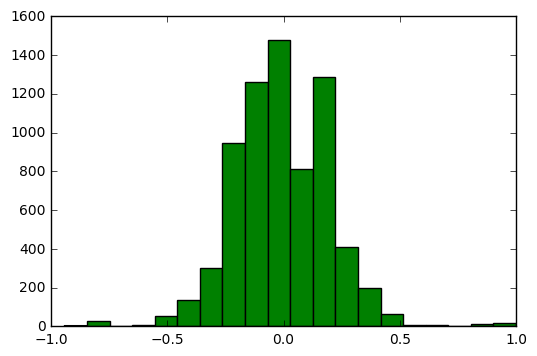

In [11]:
from PIL import Image
from PIL import ImageOps
from random import random
# create list for data
X = []
# create list for labels]
y = []

# Transformtations to augment the data set
def mirror(image, label):
    mirr_img = ImageOps.mirror(image) 
    label = label * -1 #(-(random() * 0.1 +1.)) ## add little offset so the image is not exactly the same
    return (mirr_img, label)

## Remove the images with steering angle == 0, with 60% probability to not be removed
## i.e. remove 40% randomly
for i, (lbl, img) in enumerate(zip(steering_angles, center_imgs_path)):
    if  -0.095 < lbl <= 0.008 and random() >=0.4:
        steering_angles.pop(i)
        center_imgs_path.pop(i)        

for label, data in zip(steering_angles, center_imgs_path):
    # Increase the data set.
    # crop data to our defined area of interest    
    #X.append(np.asarray(Image.open(data).crop((0,BOTTOM_MARGIN,320,TOP_MARGIN)).convert('1')))
    X.append(Image.open(data).crop((0,BOTTOM_MARGIN,320,TOP_MARGIN)).resize((160,45)))
    y.append(label)


neg_imgs = sum(n[0:9])
pos_imgs = sum(n[11:19])
print("negative images count: " + str(sum(n[0:9])) )
print("postivie images count: " + str(sum(n[11:19])) )

ratio_np = neg_imgs/pos_imgs
print("ratio: " + str(ratio_np))
if ratio_np > 1.2:
    #noImgs = abs(int((len(X) * (1.0 - ratio_np)) )) - pos_imgs
    noImgs = neg_imgs - pos_imgs
    print("Adding " + str(noImgs) + " more images")
    for img, label in zip(X,y):
        if label < -0.1 and random() > 0.7:
            if noImgs > 0:
                noImgs -=1
                new_Img, new_label = mirror(img, label)
                X.append(new_Img)

                y.append(new_label)

print(len(X))
print(len(y))



### Re print the graph

n, bins, _ = plt.hist(y, facecolor='green',  bins=20)
print("New negative images count: " + str(sum(n[0:9])) )
print("New postivie images count: " + str(sum(n[11:19])) )
ext_X = []
for nx in X:
    ext_X.append(np.asarray(nx))
del X
X = 
plt.xlabel('Steering angle')
plt.ylabel('Number of images in the range')
plt.grid(True)
plt.show()


In [ ]:
import gc
gc.collect()
plot_imgArr(X[10:14], label=y[10:14], gray=True) ## Print olny 4 images

Convert to float and add dimension for the labels. 
Also normalize the RGB values. 

In [ ]:
import cv2
X = np.asarray(X).astype('float32')
X_norm = []
for img in X:
    norm_image = cv2.normalize(img, dst=img.copy(), alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_norm.append(norm_image)

plot_imgArr(X_norm[100:104], gray=True)
X = np.asarray(X_norm)
del X_norm
y = np.asarray(y).astype('float32')
y = y.reshape((y.shape[0],1))
print(X.shape)
print(y.shape)

From the images we can see that the normalization clears the image.

Now using sklearn tools shuffle and get the validation data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
gc.collect()
#X = X.reshape((X.shape[0],X.shape[1],X.shape[2], 1))
X,y = shuffle(X,y)

#plot_imgArr(X[100:104], label=y[100:104], gray=True)

In [ ]:
X, X_val, y, y_val = train_test_split(X, y, random_state=0, test_size=0.2)
print(X.shape)


## Naive implementation:

In this implementation I want to measure the influence of the preprocessing in the behaviour of the network.
For this Keras will be fetching the data I have stored of 4 laps in the simulator.

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
#from keras.utils.visualize_util import plot
# Current shape: 90x320x3

# Instantiate a Sequential model
model = Sequential()
# Add first convolution layer
model.add(Convolution2D(1,1,1, border_mode='same', input_shape=(X.shape[1],X.shape[2],X.shape[3]), dim_ordering='tf'))
# shape ()
model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='tanh'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.75))

model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='tanh'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.75))

model.add(Convolution2D(48, 3, 3, border_mode='valid', activation='tanh'))
model.add(MaxPooling2D((2,4),(4,4),'valid'))
model.add(Dropout(0.75))

model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='tanh'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.75))

model.add(Flatten())
model.add(Dense(1164, activation='tanh'))
model.add(Dense(100,activation='tanh'))
model.add(Dense(50,activation='tanh'))
model.add(Dense(10,activation='tanh'))
model.add(Dense(1,activation='tanh'))
model.summary()
# TODO

#plot(model, to_file='model.png')

In [ ]:
from keras.optimizers import Adam
adam_opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
model.compile(loss='mean_squared_error',optimizer=adam_opt)
log = model.fit(X, y,batch_size=40, nb_epoch=7, verbose=1, validation_data=(X_val, y_val))

Save the Model and Data

In [ ]:
open("model.json", "w").write(model.to_json())
model.save_weights("model.h5")

In [ ]:
# test in the data from the autonomous mode
dbg_imgs = glob("*.png")
dX = []
dy = []

for img in dbg_imgs:
    dX.append(plt.imread(img)) 
    dy.append(str(img.replace(".png", "")))

sli = np.asarray(dX[10:14])
print(type(sli))
#sli = sli.reshape((None, sli.shape[2] ))
pred = model.predict(sli)
print(pred)
lp = list(map(str, pred))
## TODO: is the image returned by the simulation in the same color space?
## TODO: Debug the Drive.py script to check if there is the problem with the prediciton and not in the network.
print(dy[10:14])
plot_imgArr(dX[10:14],dy[10:14], lp)

Plot some images and the predicted steering angle for a quick comparison.

In [ ]:
pred = model.predict(X[190:194])
plot_imgArr(X[190:194],y[190:194], pred)
pred

I was getting a bad result in my training, the loss was not being modified, then the learning rate and the batch size were modified. The specific result can be consulted in:
https://github.com/yhoazk/CarND-Behavioral-Cloning-P3/blob/5dadaf1ab68a706e51c5961282140a714a9500ce/ExploreAndPreprocessData.ipynb

The results changed when I changed the activation function from relu to tanh

### Learning Note:

As our data contains a lot of zeros as expected output, the Relu units "die". This means that they are never activated.
Here is an excerpt from Stanfords course on neural networks:

```
"Unfortunately, ReLU units can be fragile during training and can "die". For example, a large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. That is, the ReLU units can irreversibly die during training since they can get knocked off the data manifold. For example, you may find that as much as 40% of your network can be "dead" (i.e. neurons that never activate across the entire training dataset) if the learning rate is set too high. With a proper setting of the learning rate this is less frequently an issue."
``` [http://cs231n.stanford.edu/]


#### Run the simulator:

In [ ]:
import subprocess
subprocess.Popen([SIMULATOR_DIR + "Default Linux desktop Universal.x86_64"])